In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Detection

In [2]:
class BallDetector:

    def __init__(self, hue_min, hue_max, saturation, value, kernel_size, min_area, flimits):
        self.hue_min = hue_min
        self.hue_max = hue_max
        self.saturation = saturation
        self.value = value
        self.kernel_size = kernel_size
        self.min_area = min_area
        self.flimits = flimits

    def detect(self, img):
        
        seg = self.segmentation(img)
        seg = self.post_processing(seg)
        
        curve = self.polygonal_curve_detection(seg)
        
        return seg, curve

    def segmentation(self, img):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        h = hsv[:, :, 0]
        s = hsv[:, :, 1]
        v = hsv[:, :, 2]
        
        color_segment = (
            np.logical_and(
                h > self.hue_min,
                h <= self.hue_max)
            if self.hue_min < self.hue_max
            else 
            np.logical_or(
                h > self.hue_min,
                h < self.hue_max))
        
        binary = np.logical_and.reduce([
            color_segment,
            s > self.saturation,
            v > self.value
            ])
        binary = binary * 255
        
        return binary.astype('u1')
        
    
    def post_processing(self, img):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (self.kernel_size, self.kernel_size))
        binary = cv2.erode(img, kernel)
        binary = cv2.dilate(binary, kernel)
        # binary = cv2.GaussianBlur(binary, (5,5), 2,2)
        return binary

    def polygonal_curve_detection(self, binary):
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        contours = [ cv2.convexHull(c) for c in contours ]

        if len(contours) == 0:
            return None

        contourAreas = [ cv2.contourArea(c) for c in contours ]
        contourId = np.argmax(contourAreas)
        contour = contours[contourId]

        area = cv2.contourArea(contour)
        bbox = cv2.boundingRect(contour)
        bbox = tuple(map(float, bbox))
        radius = bbox[2] / 2

        if area < self.min_area:
            return None

        ffac1 = np.abs(1 - (bbox[2] / bbox[3]))
        ffac2 = np.abs(1 - area / (np.pi * radius * radius))
        
        is_circle = ffac1 < self.flimits[0] and ffac2 < self.flimits[1]
        if not is_circle:
            return None

        centroid = ( (bbox[0] + radius, bbox[1]+ radius), radius )

        return centroid

    def hough_lines(self):
        return None

## Hyperparameter Adjusting

In [3]:
import ipywidgets as widgets
from ipywidgets.widgets import interact, interact_manual
from ipywidgets.widgets import (IntSlider, FloatSlider)

In [4]:
from glob import glob

In [5]:
imgs = glob('top_left_camera/*.png')[:30]

In [6]:
imgs = [cv2.imread(img) for img in imgs]
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs ]

In [7]:
@interact_manual(
    hue_max=IntSlider(min=0, max=180, value=20),
    hue_min=IntSlider(min=0, max=180, value=170),
    saturation=IntSlider(min=0, max=255, value=150),
    value=IntSlider(min=0, max=255, value=30),
    min_area=FloatSlider(min=1000, max=20000, value=10000),
    kernel_size=IntSlider(min=3, max=15, value=5),
    flim1=FloatSlider(min=0, max=1, value=0.10),
    flim2=FloatSlider(min=0, max=1, value=0.15),)
def f(hue_min, hue_max, saturation, value, min_area, kernel_size, flim1, flim2):
    fig, axarr = plt.subplots(5,6, figsize=(15,12))
    ax = axarr.flatten()
    
    bd = BallDetector(hue_max=hue_max,
                      hue_min=hue_min,
                      saturation=saturation,
                      value=value,
                      kernel_size=kernel_size,
                      min_area=min_area,
                      flimits=(flim1, flim2))
    
    segmentations, detections = zip(*[ bd.detect(img) for img in imgs ])
    
    for i in range(30):
        ax[i].axis('off')
        ax[i].imshow(imgs[i], alpha=1)
        ax[i].imshow(segmentations[i], cmap='gray', alpha=0.5)
        ax[i].legend(str(i))

        if detections[i] is not None:
            t = np.linspace(0, 2 * np.pi, 200)

            (x, y), r = detections[i]
            x += r * np.cos(t)
            y += r * np.sin(t)
            ax[i].plot(x, y, c='r')
        

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xNzAsIGRlc2NyaXB0aW9uPXUnaHVlX21pbicsIG1heD0xODApLCBJbnRTbGlkZXIodmFsdWU9MjAsIGRlc2NyaXB0aW9uPXXigKY=


## Detect the ball in all frames

In [8]:
from tqdm import tqdm_notebook
from os.path import split

In [9]:
imgs = glob('top_left_camera/*.png')
imgs = sorted(imgs)

Initialize the ball detector with the best parameters

In [10]:
bd = BallDetector(hue_max=20,
                  hue_min=170,
                  saturation=150,
                  value=30,
                  kernel_size=5,
                  min_area=8000,
                  flimits=(0.10, 0.15))

In [11]:
detections = []
timestamps = []
for img in tqdm_notebook(imgs):
    _, name = split(img)
    timestamp = name[:-4]
    
    im = cv2.imread(str(img))
    rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    _, detection = bd.detect(rgb)
    
    if detection is not None:
        detections.append(detection)
        timestamps.append(timestamp)

# Create annotated video from images

In [ ]:
video_writer = cv2.VideoWriter('./video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (964, 724))

for img in tqdm_notebook(imgs):
    im = cv2.imread(str(img))
    rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    _, detection = bd.detect(rgb)

    if detection is not None:
        (x, y), r = detection
        
        im = cv2.circle(im, (int(x), int(y)), int(r), (0, 255, 0), 4)
    
    video_writer.write(im)

video_writer.release()

# Transform 2D detection into 3D points

## Camera Intrinsics

In [12]:
fx = 1167.914995
fy = 1178.789838
favg = (fx + fy) / 2
cx = 505.998418
cy = 375.348091
K = np.array([fx, 0, cx, 0, fy, cy, 0, 0, 1]).reshape(3,3)

In [13]:
ball_diameter = 2.24 / (np.pi)
ball_diameter

0.7130141450516913

## Mapping 

In [14]:
import numpy.linalg as la

In [15]:
def uvz2xyz(detection):
    (x, y), r = detection
    
    dist = favg * ball_diameter / r / 2
    p = np.array([x, y, 1]).astype('f4')
    
    return dist * la.inv(K).dot(p)

In [16]:
points = map(uvz2xyz, detections)
points = list(points)
points = np.array(points)

In [17]:
### Smooth the points

In [18]:
chunks = np.array_split(points, points.shape[0] // 10)
points_smooth = map(lambda c: np.mean(c, axis=0), chunks)
points_smooth = np.stack(points_smooth)

## The Path of the ball

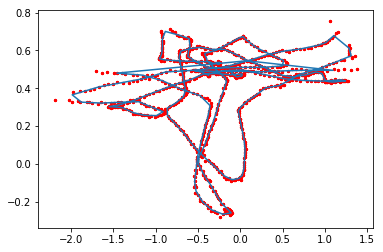

In [19]:
plt.plot(points_smooth[:, 0], points_smooth[:, 1])
plt.scatter(points[:, 0], points[:, 1], s=5, c='red')